In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadr 
from scipy import stats

d:\anaconda_files\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
df = pyreadr.read_r("okc.RData")
df.keys()

odict_keys(['okc_test', 'okc_train', 'okc_down', 'okc_sampled'])

In [4]:
df["okc_down"]["Class"].value_counts()

other    7167
stem     7167
Name: Class, dtype: int64

In [5]:

df_okc = df["okc_down"]

In [6]:
df_okc["age"].dtype

dtype('int32')

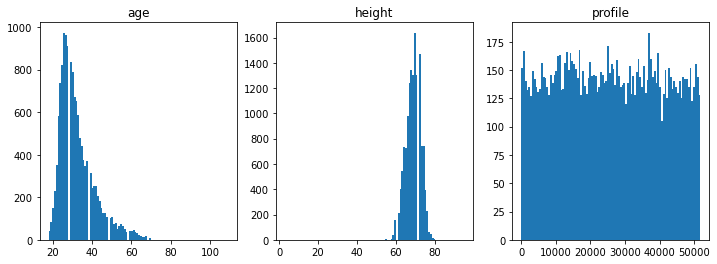

In [7]:
num_features = []
for i in df_okc.columns:
    if df_okc[i].dtype == "int32":
        num_features.append(i)
fig, axis = plt.subplots(1, len(num_features), figsize=(12, 4))
for i, j in enumerate(num_features):
    axis[i].hist(df_okc[j], bins=100)
    axis[i].set_title(j)



In [8]:
#creating dummies
df_dummies = pd.get_dummies(df_okc.drop(columns=['Class']))
df_dummies.shape
df_dummies = pd.concat([df_dummies, df_okc["Class"]], axis= 1)

In [9]:
df_dummies["Class"].value_counts()

other    7167
stem     7167
Name: Class, dtype: int64

In [10]:
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_dummies["Class"] = le.fit_transform(df_dummies["Class"])
X_train, X_test, y_train, y_test = train_test_split(df_dummies.drop(columns=["Class"]), df_dummies['Class'], test_size=0.2, shuffle = True, random_state=42)
#stem_weight = df_okc['Class'].value_counts()[0] / df_okc['Class'].value_counts()[1]
#print(stem_weight)
#weights = {0: stem_weight*.695, 1": 1}
clf = LogisticRegression(penalty = "l1",solver = "liblinear", class_weight = "balanced")
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train),
    clf.score(X_test, y_test))


0.7113456004185925 0.7003836763167074


In [11]:
y_test.value_counts()

1    1438
0    1429
Name: Class, dtype: int64

In [12]:
confusion_matrix(y_train, clf.predict(X_train))

array([[4082, 1656],
       [1654, 4075]], dtype=int64)

In [13]:
from sklearn.metrics import recall_score, precision_score, cohen_kappa_score
print(recall_score(y_train, clf.predict(X_train)), precision_score(y_train, clf.predict(X_train)), cohen_kappa_score(y_train, clf.predict(X_train)))

0.7112934194449293 0.7110451928110277 0.4226910032670874


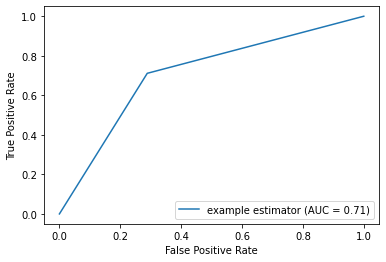

In [14]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
y_pred = (clf.predict_proba(X_train)[:, 1] > .50).astype('float')
fpr, tpr, thresholds = roc_curve(y_train, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,  estimator_name='example estimator')
display.plot()

In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from  torch.optim.lr_scheduler import StepLR
import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [16]:
class okcupidata(Dataset):
    def __init__(self, df, target):
        self.df = df
        self.target = target
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        return torch.tensor(self.df.iloc[idx]), torch.tensor(self.target.iloc[idx])

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(X_train.values)
x_test =  scaler.fit_transform(X_test.values)
x_tensor =  torch.from_numpy(x_train).float()
y_tensor =  torch.from_numpy(y_train.values.ravel()).float()
xtest_tensor =  torch.from_numpy(x_test).float()
ytest_tensor =  torch.from_numpy(y_test.values.ravel()).float()
y_tensor = y_tensor.unsqueeze(1)
train_ds = TensorDataset(x_tensor, y_tensor)
train_dl = DataLoader(train_ds, batch_size=64,  shuffle=True)
ytest_tensor = ytest_tensor.unsqueeze(1)
test_ds = TensorDataset(xtest_tensor, ytest_tensor)
test_loader = DataLoader(test_ds, batch_size=64)

In [18]:
zero_connt = 0
one_count = 0
for i, (j, m) in enumerate(train_dl):
    for k in m:
        if k == torch.tensor(0):
            zero_connt += 1
        else:
            one_count += 1
print(zero_connt, one_count)

5738 5729


In [19]:
class logisticrig(nn.Module):
    def __init__(self):
        super(logisticrig, self).__init__()
        self.layer_1 = nn.Linear(239, 1) 
        self.sigmoid =  nn.Sigmoid()

    def forward(self, inputs):
        x = self.layer_1(inputs)
        x = self.sigmoid(x)
        return x
model = logisticrig()

In [51]:
n_hidden1 = 24  # Number of hidden nodes
n_hidden2 = 12
class CupidModel(nn.Module):
    def __init__(self):
        super(CupidModel, self).__init__()
        self.layer_1 = nn.Linear(239, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, 1)
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1, track_running_stats=False)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x
    

model = CupidModel()

In [52]:
optimizer = optim.RMSprop(model.parameters(), lr=.0001, weight_decay=0, momentum=0, centered=False) 
scheduler = StepLR(optimizer, step_size=1, gamma=0.04458)
loss_fn = nn.BCELoss()

In [53]:
model.train()
for epoch in range(50):
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        #print(output, target.float().unsqueeze(1))
        l2_lambda = 0.001
        l2_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()
    #scheduler.step()
    if epoch % 10 == 0:
        print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, loss.item()))

Train Epoch: 0 	Loss: 0.850525
Train Epoch: 10 	Loss: 0.804592
Train Epoch: 20 	Loss: 0.606474
Train Epoch: 30 	Loss: 0.692050
Train Epoch: 40 	Loss: 0.484138


In [54]:
# model evaluation on training set

import itertools

y_pred_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for xb_test,yb_test  in test_loader:
        y_test_pred = model(xb_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())
        

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))

In [55]:
y_true_test = y_test.values.ravel()
conf_matrix = confusion_matrix(y_true_test ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(y_true_test,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(y_true_test,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(y_true_test,ytest_pred)))
print("Accuracy of the Model :\t"+str(accuracy_score(y_true_test,ytest_pred)))

Confusion Matrix of the Test Set
-----------
[[1038  391]
 [ 515  923]]
Precision of the MLP :	0.7024353120243532
Recall of the MLP    :	0.6418636995827538
F1 Score of the Model :	0.6707848837209303
Accuracy of the Model :	0.6839902336937566


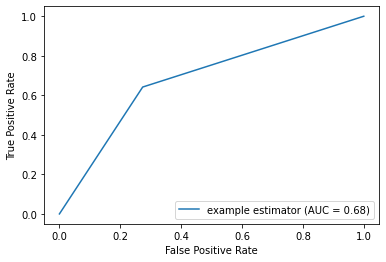

In [56]:
fpr, tpr, thresholds = roc_curve(y_true_test,ytest_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,  estimator_name='example estimator')
display.plot()

In [57]:
# model evaluation on training set

y_pred_list = []
y_true_list = []
model.eval()
#Since we don't need model to back propagate the gradients in test set we use torch.no_grad()
# reduces memory usage and speeds up computation
with torch.no_grad():
    for i, (xb_train,yb_train)  in enumerate(train_dl):
        y_train_pred = model(xb_train)
        y_pred_tag = torch.round(y_train_pred)
        y_pred_list.append(y_pred_tag.detach().numpy())
        y_true_list.append(yb_train.detach().numpy())

#Takes arrays and makes them list of list for each batch        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_true_list = [a.squeeze().tolist() for a in y_true_list]
#flattens the lists in sequence
ytest_pred = list(itertools.chain.from_iterable(y_pred_list))
ytest_true = list(itertools.chain.from_iterable(y_true_list))

In [58]:
conf_matrix = confusion_matrix(ytest_true ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Precision of the MLP :\t"+str(precision_score(ytest_true,ytest_pred)))
print("Recall of the MLP    :\t"+str(recall_score(ytest_true,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(ytest_true,ytest_pred)))
print("Accuracy of the Model :\t"+str(accuracy_score(ytest_true,ytest_pred)))

Confusion Matrix of the Test Set
-----------
[[4313 1425]
 [1437 4292]]
Precision of the MLP :	0.750743396886479
Recall of the MLP    :	0.7491708849711992
F1 Score of the Model :	0.749956316617159
Accuracy of the Model :	0.7504142321444144
